In [1]:
import torch
import MiniFL as mfl

In [2]:
NUM_CLIENTS = 1
NUM_FEATURES = 300

In [3]:
def get_task():
    # return mfl.tasks.get_w8a_regression_fns(
    #     data_path="w8a",
    #     num_clients=NUM_CLIENTS,
    #     batch_size=-1,
    # )
    return mfl.tasks.create_worst_case_tridiagonal_quadratics(
        num_clients=NUM_CLIENTS,
        size=4,
    )

In [4]:
GD_STEPS = 100

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_gd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma_multiplier=1,
)

GD_METRICS = await mfl.algorithms.run_algorithm(master, clients, GD_STEPS)

100%|██████████| 100/100 [00:00<00:00, 1330.42it/s]


In [5]:
MARINA_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_marina_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    compressors=[mfl.compressors.RandKUnbiasedCompressor(NUM_FEATURES, k=1) for _ in range(NUM_CLIENTS)],
    p=0.01,
    gamma_multiplier=0.1,
)

MARINA_METRICS = await mfl.algorithms.run_algorithm(master, clients, MARINA_STEPS)

100%|██████████| 1000/1000 [00:01<00:00, 981.81it/s]


In [6]:
PERM_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_permk_marina_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    p=0.01,
    gamma_multiplier=0.1,
)

PERM_METRICS = await mfl.algorithms.run_algorithm(master, clients, PERM_STEPS)

100%|██████████| 1000/1000 [00:00<00:00, 1099.17it/s]


In [7]:
COCKTAIL_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_cocktailgd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma=1,
    rand_p=0.2,
    top_p=0.2,
    # p=0.1,
)

COCKTAIL_METRICS = await mfl.algorithms.run_algorithm(master, clients, COCKTAIL_STEPS)


100%|██████████| 1000/1000 [00:01<00:00, 707.24it/s]


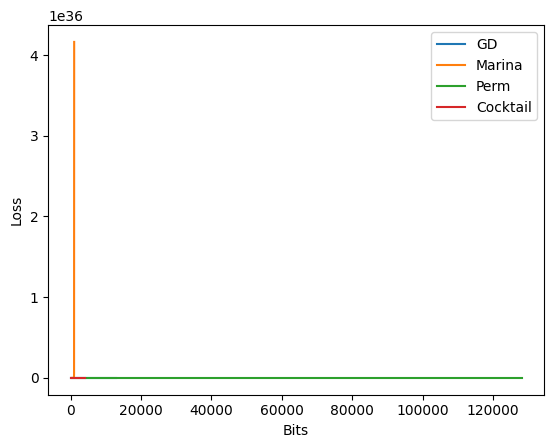

In [8]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received for metrics in GD_METRICS], [metrics.value for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received for metrics in MARINA_METRICS], [metrics.value for metrics in MARINA_METRICS], label="Marina")
plt.plot([metrics.total_bits_received for metrics in PERM_METRICS], [metrics.value for metrics in PERM_METRICS], label="Perm")
plt.plot([metrics.total_bits_received for metrics in COCKTAIL_METRICS], [metrics.value for metrics in COCKTAIL_METRICS], label="Cocktail")

plt.xlabel("Bits")
plt.ylabel("Loss")
plt.legend()

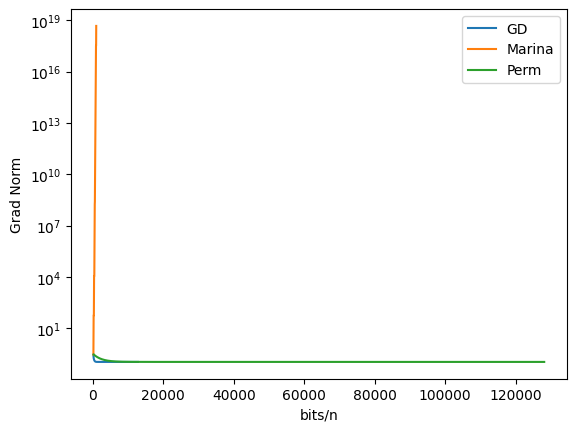

In [9]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in GD_METRICS], [metrics.grad_norm for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in MARINA_METRICS], [metrics.grad_norm for metrics in MARINA_METRICS], label="Marina")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in PERM_METRICS], [metrics.grad_norm for metrics in PERM_METRICS], label="Perm")
plt.yscale("log")

plt.xlabel("bits/n")
plt.ylabel("Grad Norm")
plt.legend()